In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Tutorial.Dataset  import load_scg
import pywt


In [7]:
def load_simulated_data_RR():
    data_train = np.load('D:\PHD\Research\Data\\Normal\sim_5000_0_90_140_train_normal.npy')
    data_test = np.load('D:\PHD\Research\Data\\Normal\sim_3000_0_141_178_test_normal.npy')

    signals_train, labels_train = data_train[:, :1000], data_train[:, 1000:]
    signals_test, labels_test = data_test[:, :1000], data_test[:, 1000:]

    def filter_signals(signals, labels):
        idx = np.any(signals > 1, axis=1)
        return signals[~idx], labels[~idx]

    filtered_signals_train, filtered_labels_train = filter_signals(signals_train, labels_train)
    filtered_signals_test, filtered_labels_test = filter_signals(signals_test, labels_test)

    print(filtered_signals_train.shape, filtered_labels_test.shape)
    return filtered_labels_train, filtered_labels_test, filtered_signals_train, filtered_signals_test

In [2]:
def load_simulated_data(noise_level=0):
    signals_train, labels_train, duration, fs = load_scg(noise_level, 'train')
    signals_test, labels_test, _, _ = load_scg(noise_level, 'test')

    def filter_signals(signals, labels):
        idx = np.any(signals > 1, axis=1)
        return signals[~idx], labels[~idx]

    filtered_signals_train, filtered_labels_train = filter_signals(signals_train, labels_train)
    filtered_signals_test, filtered_labels_test = filter_signals(signals_test, labels_test)

    print(filtered_signals_train.shape, filtered_labels_test.shape)
    return filtered_labels_train, filtered_labels_test, filtered_signals_train, filtered_signals_test

In [8]:
labels_0_train, labels_0_test, signals_0_train, signals_0_test = load_simulated_data(0)
labels_0_train_RR, labels_0_test_RR, signals_0_train_RR, signals_0_test_RR = load_simulated_data_RR()


(4718, 1000) (2822, 6)
(4687, 1000) (2853, 6)


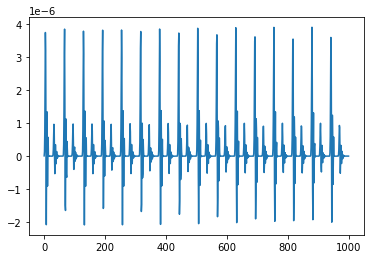

In [6]:
plt.plot(signals_0_train[0])

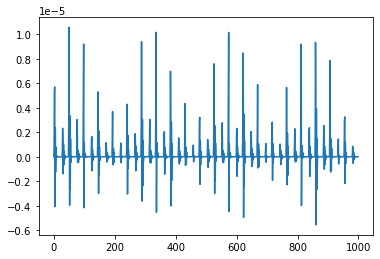

In [9]:
plt.plot(signals_0_train_RR[0])

##### 累加能够看到scg信号中的呼吸模式
但是不知道为什么，这个呼吸的模式会出现shift

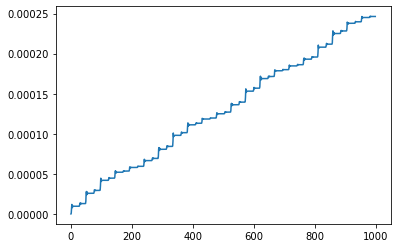

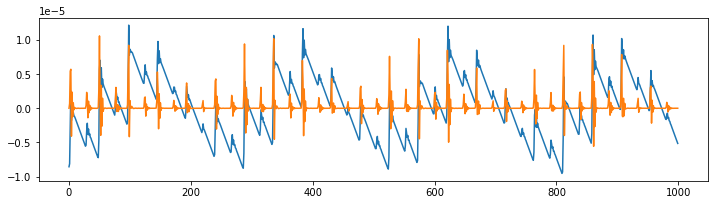

D:\ANACONDA\envs\pytorch\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


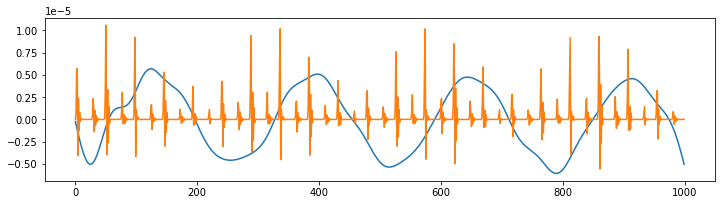

In [18]:
def get_freq(sampling_rate, level):
    freqs = []
    freq_top = sampling_rate * 0.5
    for i in range(1, level+1):
        start, end = freq_top * 0.5, freq_top
        freqs.append((start, end))
        freq_top = start
    freqs.append((0, freq_top))
    return freqs[::-1]

def wavelet_denoise_select_RR(signals, level, wavelet, sampling_rate, show=False):
    filtered_signals = []
    for signal in signals:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dep_freqs = get_freq(sampling_rate, level)

        # coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:3] + [np.zeros_like(c) for c in coeffs[3:]]

        intern = 2
        coeffs_filtered = coeffs[:intern] + [np.zeros_like(c) for c in coeffs[intern:]]
        reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
        if show:
            print(dep_freqs[1:5])
            plt.figure(figsize=(12, 5))
            plt.plot(signal, label='Noisy Signal')
            plt.plot(reconstructed_signal, label='Filtered Signal')
            plt.legend()
            plt.show()
            break

        filtered_signals.append(reconstructed_signal)
    return np.array(filtered_signals)

from scipy import signal


wavelet = 'db12'
level = 6
sampling_rate = 100

# plt.plot(signals_0_train_RR[0])
# plt.show()
cumsum_goods_signals = np.cumsum(signals_0_train_RR, 1)
plt.plot(cumsum_goods_signals[0])
plt.show()
plt.figure(figsize=(12, 3))

plt.plot(signal.detrend(cumsum_goods_signals[0]))
plt.plot(signals_0_train_RR[0])
plt.show()
filtered_cumsum_signals = wavelet_denoise_select_RR(cumsum_goods_signals, level, wavelet, sampling_rate)
plt.figure(figsize=(12, 3))
plt.plot(signal.detrend(filtered_cumsum_signals[0]))
plt.plot(signals_0_train_RR[0])

##### 对比hanning窗和方窗的特性
能够比较显著的看到各自的特性

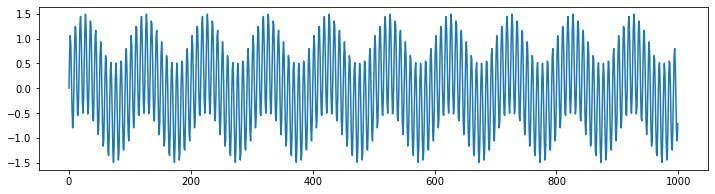

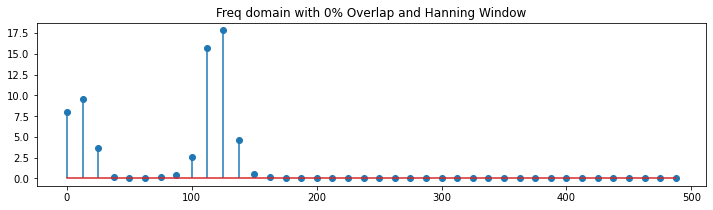

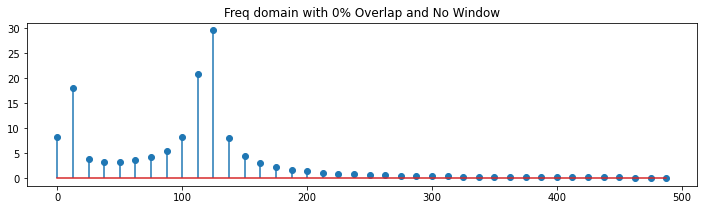

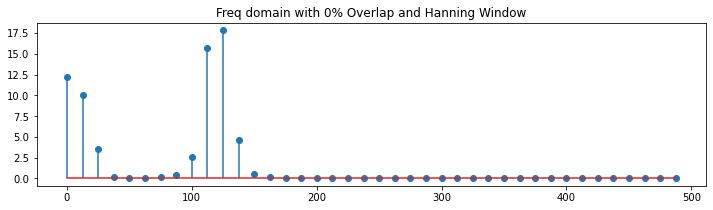

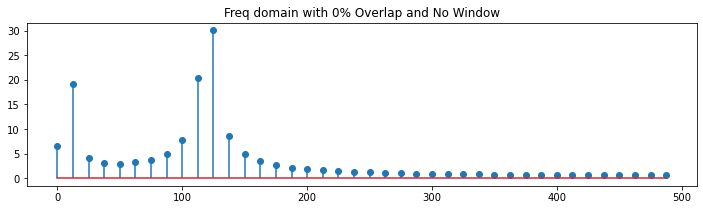

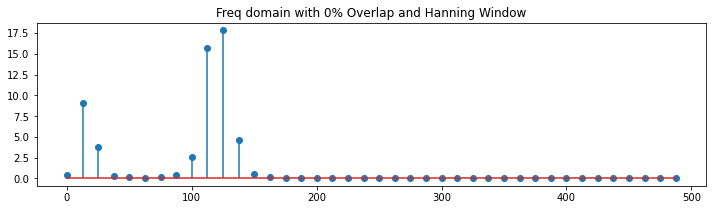

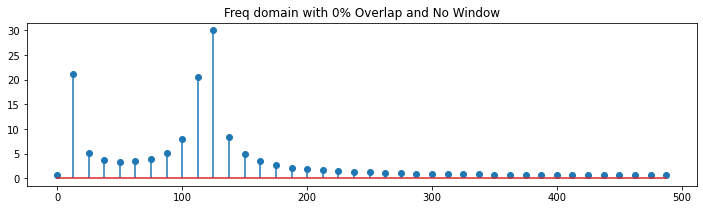

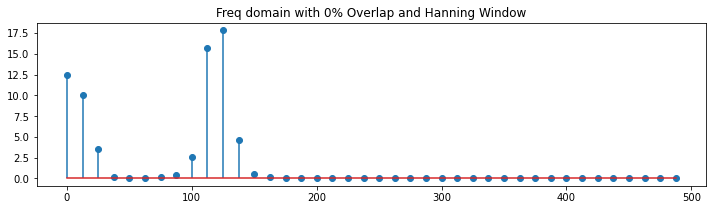

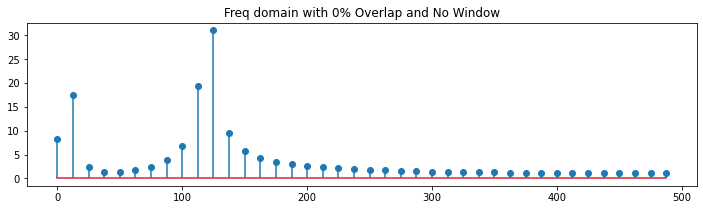

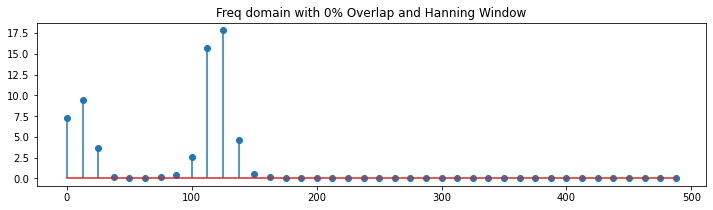

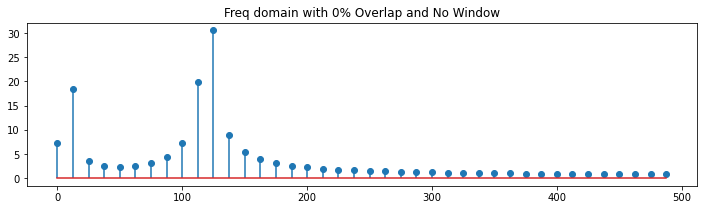

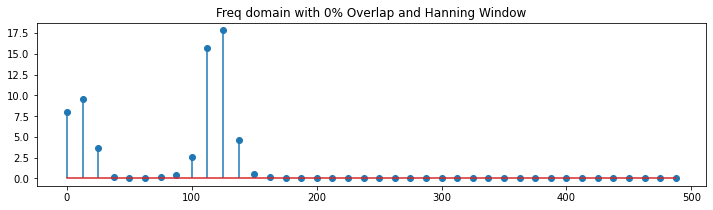

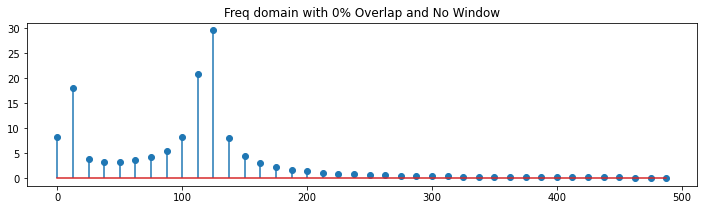

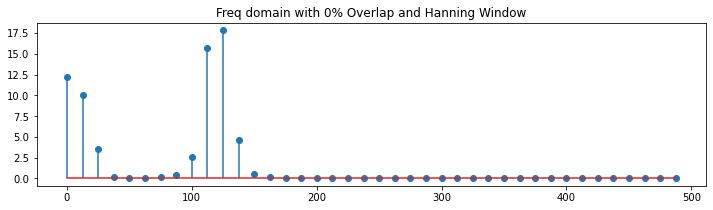

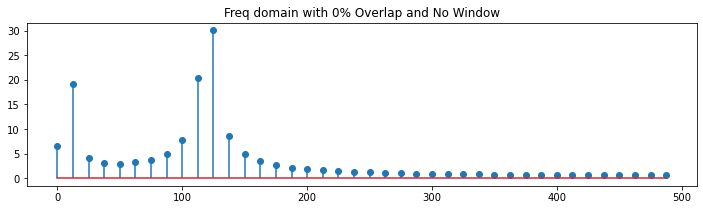

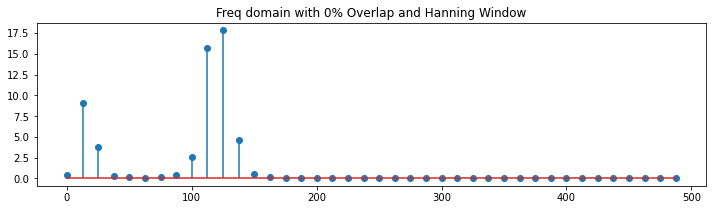

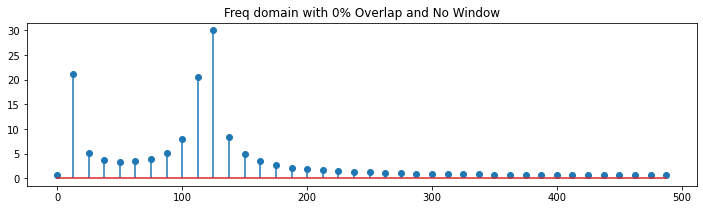

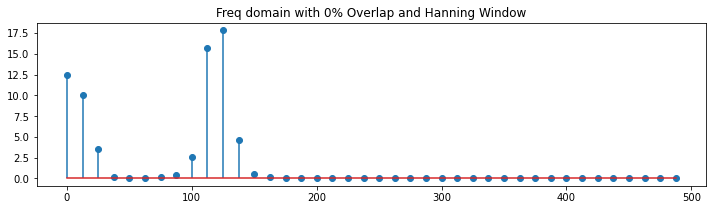

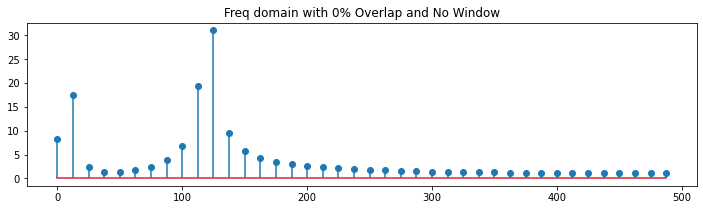

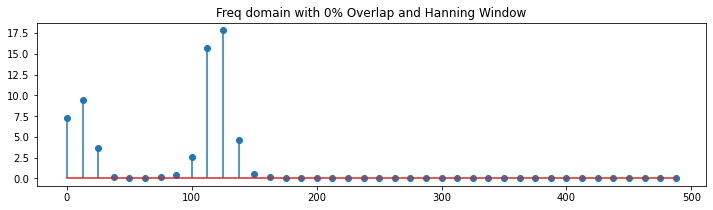

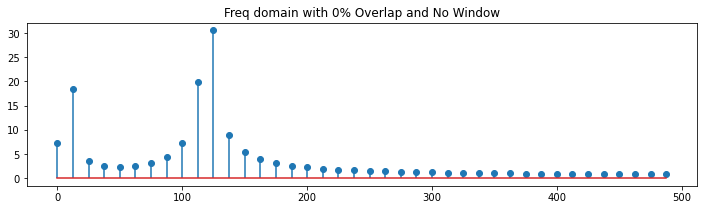

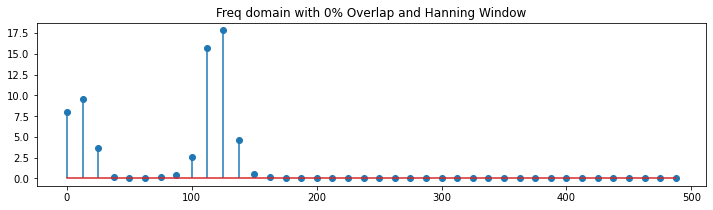

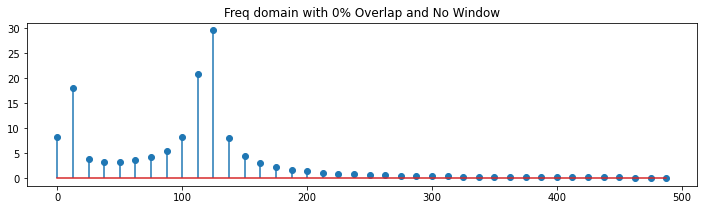

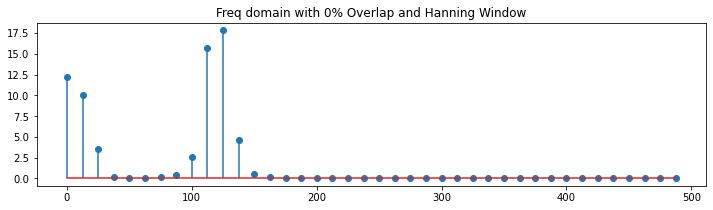

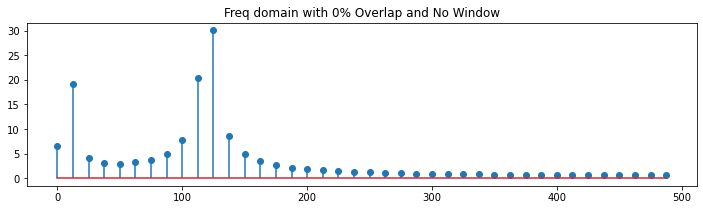

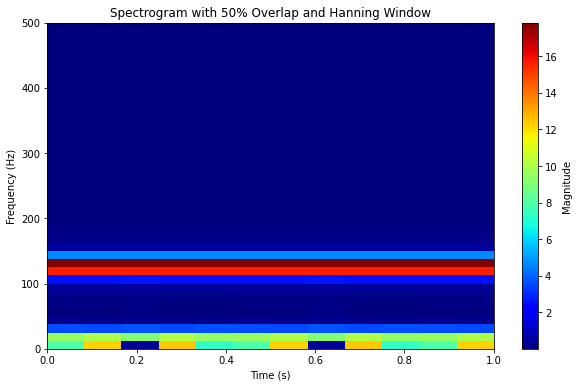

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def apply_fft_with_overlap_hanning(signal, window_size, overlap_percent):
    overlap = int(window_size * overlap_percent)
    step_size = window_size - overlap

    # 构造方窗

    fft_results = []

    # 滑动窗口并应用 FFT
    for i in range(0, len(signal) - window_size + 1, step_size):
        segment = signal[i:i + window_size] * np.hanning(window_size)
        fft_result = np.fft.fft(segment)
        fft_freq = np.fft.fftfreq(len(fft_result), 1/fs)
        plt.figure(figsize=(12, 3))
        plt.stem(fft_freq[:len(fft_freq)//2], np.abs(fft_result)[:len(fft_result)//2])
        plt.title('Freq domain with 0% Overlap and Hanning Window')
        plt.show()
        fft_results.append(fft_result)

        segment = signal[i:i + window_size] * np.ones(window_size)
        fft_result = np.fft.fft(segment)
        fft_freq = np.fft.fftfreq(len(fft_result), 1/fs)
        plt.figure(figsize=(12, 3))
        plt.stem(fft_freq[:len(fft_freq)//2], np.abs(fft_result)[:len(fft_result)//2])
        plt.title('Freq domain with 0% Overlap and No Window')
        plt.show()


    return np.array(fft_results)

# 生成示例信号
fs = 1000  # 采样率
t = np.arange(0, 1, 1/fs)
signal = np.sin(2 * np.pi * 120 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)

plt.figure(figsize=(12, 3))
plt.plot(signal)
plt.show()

window_size = 80
overlap_percent = 0
fft_results = apply_fft_with_overlap_hanning(signal, window_size, overlap_percent)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(fft_results.T[:window_size//2]), aspect='auto', cmap='jet', origin='lower', extent=[0, len(signal)/fs, 0, fs/2])
plt.colorbar(label='Magnitude')
plt.title('Spectrogram with 50% Overlap and Hanning Window')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


##### 对于scg信号，添加呼吸以后的频域，能够看出来什么

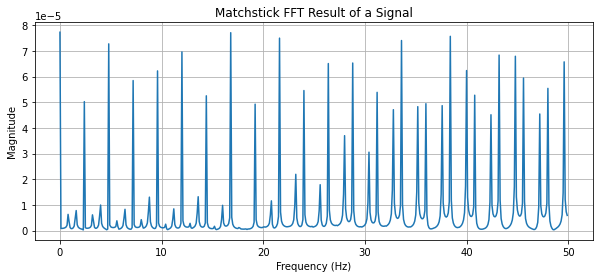

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
        12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
        13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
        14.3, 14.4, 14.5, 14.6, 14.7, 

In [72]:
def plot_fft(signal, fs):
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(fft_result), 1/fs)

    positive_freq_mask = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_mask]
    fft_result_positive = np.abs(fft_result[positive_freq_mask])

    # 绘制结果
    plt.figure(figsize=(10, 4))
    # plt.stem(fft_freq_positive, fft_result_positive)
    plt.plot(fft_freq_positive, fft_result_positive)
    plt.title('Matchstick FFT Result of a Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()
    return fft_freq_positive, fft_result_positive

# 生成示例信号
fs = 100  # 采样率
t = np.arange(0, 1, 1/fs)
idx = 1
signal = signals_0_train[idx]

# 使用函数绘制 FFT 结果
plot_fft(signal, fs)


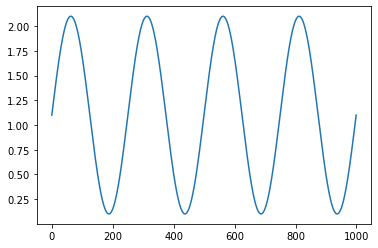

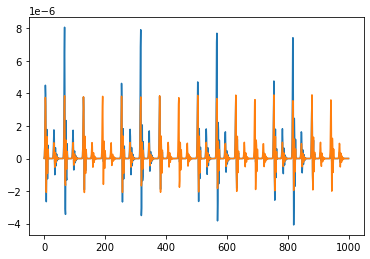

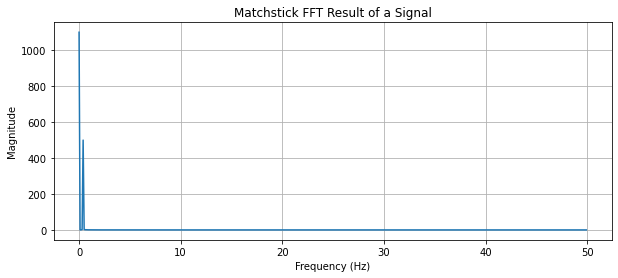

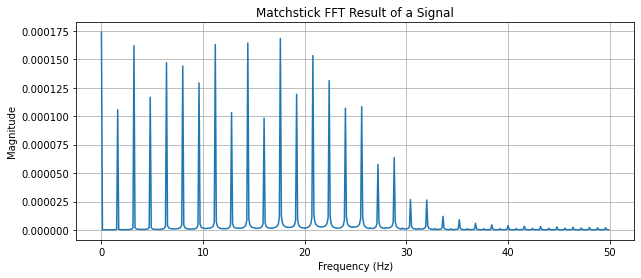

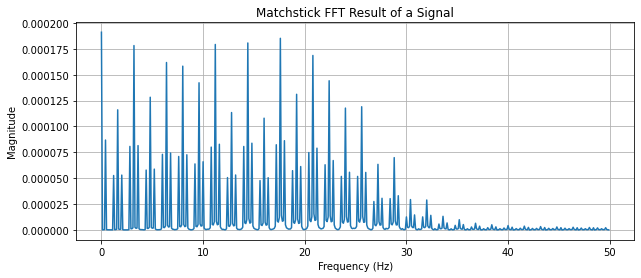

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
        12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
        13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
        14.3, 14.4, 14.5, 14.6, 14.7, 

In [86]:
fs = 100
t = np.linspace(0, 10, fs * 10)
rr = np.sin(2 * np.pi * 0.4 * t) + 1.1

plt.plot(rr)
plt.show()
# plt.plot(signals_0_train_RR[0])
plt.plot(signals_0_train[0] * rr)
plt.plot(signals_0_train[0])


plot_fft(rr, fs)
plot_fft(signals_0_train[0], fs)
plot_fft(signals_0_train[0] * rr, fs)



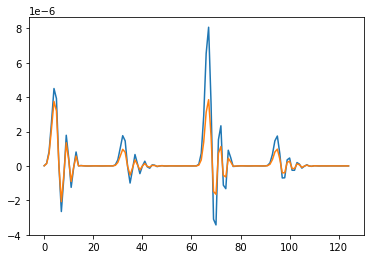

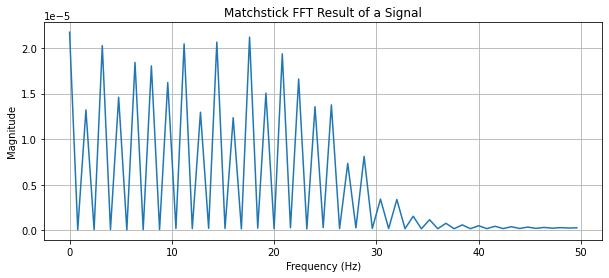

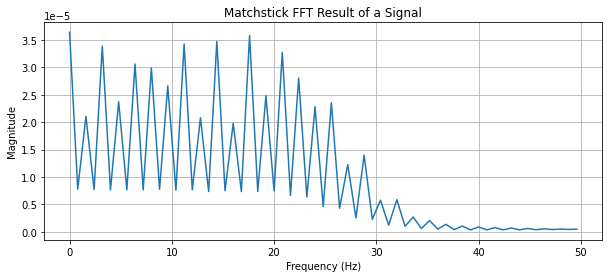

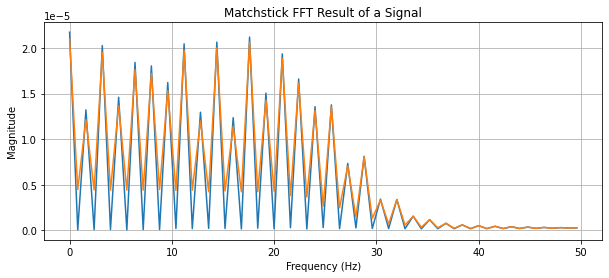

In [133]:
circle = 125
plt.plot(signals_0_train[0, :circle] * rr[:circle])
plt.plot(signals_0_train[0, :circle])


fft_freq_positive, fft_result_positive = plot_fft(signals_0_train[0, :circle], fs)
fft_freq_positive_rr, fft_result_positive_rr = plot_fft(signals_0_train[0, :circle] * rr[:circle], fs)


plt.figure(figsize=(10, 4))
# plt.stem(fft_freq_positive, fft_result_positive)
plt.plot(fft_freq_positive, fft_result_positive)
plt.plot(fft_freq_positive, fft_result_positive_rr / np.mean(rr[:circle]))
plt.title('Matchstick FFT Result of a Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


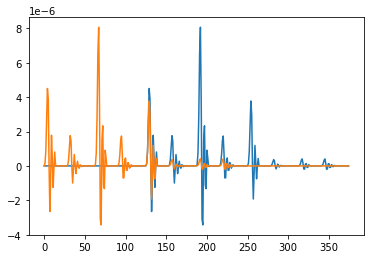

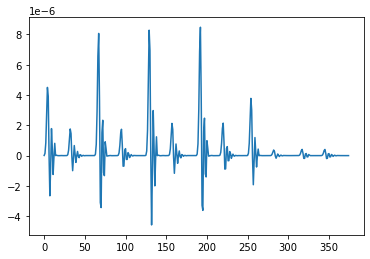

In [94]:
circle = 250
windowed_signal = signals_0_train[0, :circle] * rr[:circle]
# signals_0_train[0, :circle]
windowed_signal_l = np.pad(windowed_signal, [circle // 2, 0])
windowed_signal_r = np.pad(windowed_signal, [0, circle // 2])
plt.plot(windowed_signal_l)
plt.plot(windowed_signal_r)
plt.show()
plt.plot(windowed_signal_l + windowed_signal_r)
plt.show()


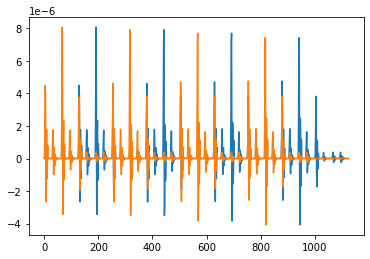

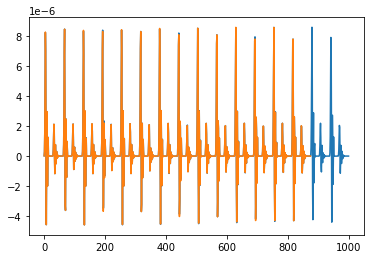

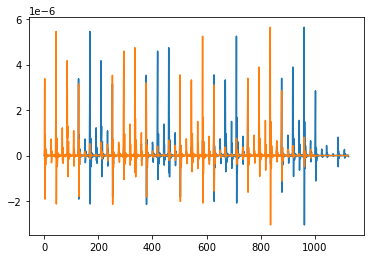

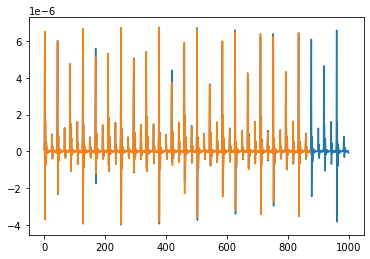

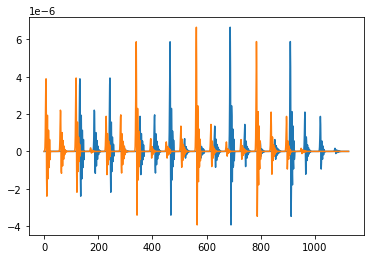

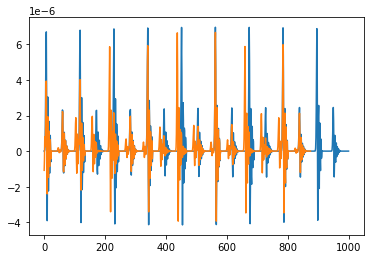

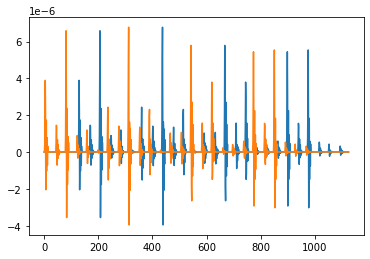

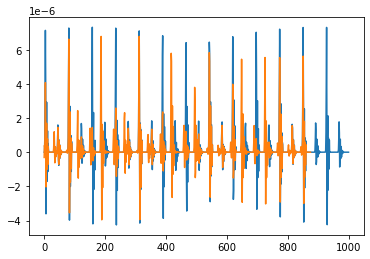

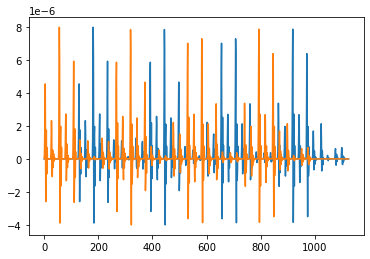

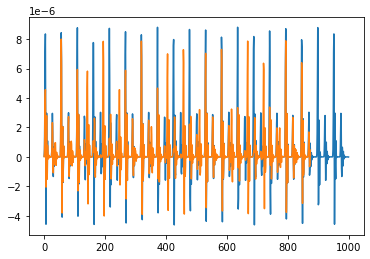

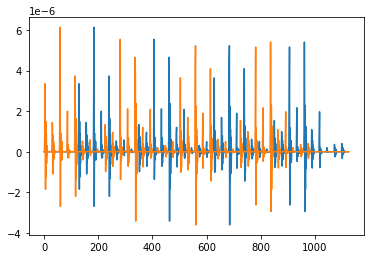

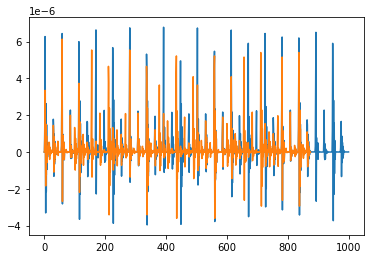

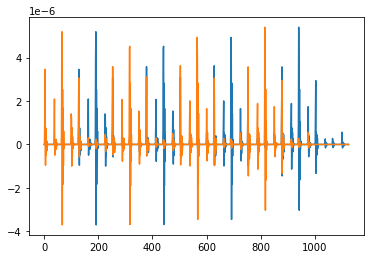

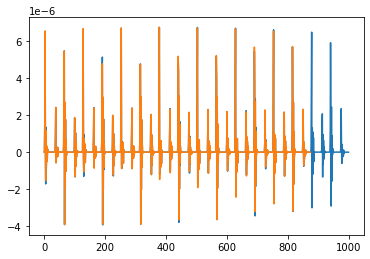

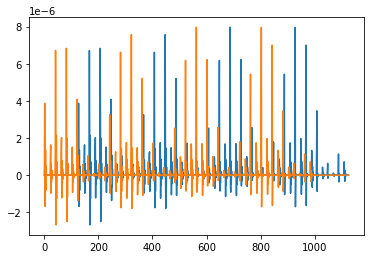

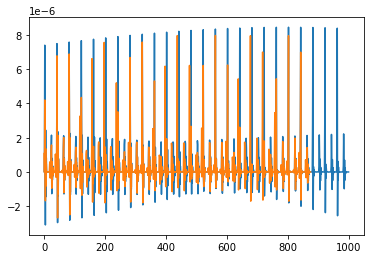

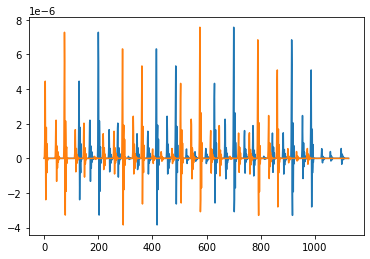

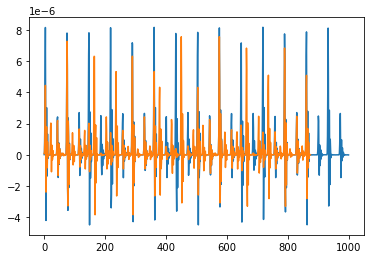

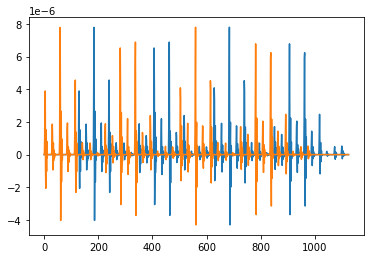

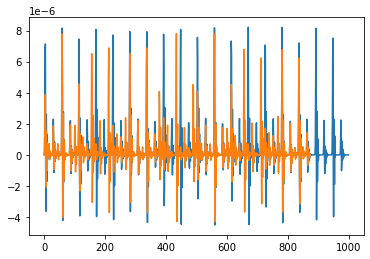

In [134]:
circle = 250
for idx in range(10):
# idx = 0
    windowed_signal = signals_0_train[idx] * rr
    # signals_0_train[0, :circle]
    windowed_signal_l = np.pad(windowed_signal, [circle // 2, 0])
    windowed_signal_r = np.pad(windowed_signal, [0, circle // 2])
    plt.plot(windowed_signal_l)
    plt.plot(windowed_signal_r)
    plt.show()
    plt.plot(signals_0_train[idx] * 2.2)
    plt.plot((windowed_signal_l + windowed_signal_r)[circle // 2: -circle // 2])


    plt.show()
# plt.plot(signals_0_train[idx] * 2.2)
# plt.show()


# plt.plot(rr)
# plt.plot(np.pad(rr, [0, circle // 2], constant_values=1.1))
# plt.plot(np.pad(rr, [circle // 2, 0], constant_values=1.1))
# plt.plot(np.pad(rr, [circle // 2, 0], constant_values=1.1) + np.pad(rr, [0, circle // 2], constant_values=1.1))
# plt.show()